In [1]:
# autoreload nangs
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# High order optimizers

We want to solve the following PDE:

\begin{equation}
    \frac{\partial \phi}{\partial t} + u \frac{\partial \phi}{\partial x} = 0
\end{equation}

The independent variables (i.e, $x$ and $t$) are used as input values for the NN, and the solution (i.e. $\phi$) is the output. In order to find the solution, at each step the NN outputs are derived w.r.t the inputs. Then, a loss function that matches the PDE is built and the weights are updated accordingly. If the loss function goes to zero, we can assume that our NN is indeed the solution to our PDE. We will try to find a general solution for different values of $u$, so it will be set also as an input.

In [2]:
# imports
import numpy as np 
import matplotlib.pyplot as plt 
import nangs
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

nangs.__version__, torch.__version__

('0.1.2', '1.5.0')

In [3]:
from nangs import PDE

U = 1
class Adv1d(PDE):
    def computePDELoss(self, inputs, outputs):
                
        # compute gradients
        grads = self.computeGrads(outputs, inputs)
        
        # compute loss
        dpdx, dpdt = grads[:, 0], grads[:, 1]
        return {'pde': dpdt + U*dpdx}
    
pde = Adv1d(inputs=('x', 't'), outputs='p')

pde.inputs, pde.outputs

(('x', 't'), ('p',))

In [4]:
from nangs import Mesh

x = np.linspace(0,1,20)
t = np.linspace(0,1,30)

mesh = Mesh({'x': x, 't': t[1:]})
pde.set_mesh(mesh)

In [5]:
# initial condition (t = 0)

_x, _t = np.meshgrid(x, t[:1])
p0 = np.sin(2*np.pi*(_x- U*_t)).ravel()
p0.shape

(20,)

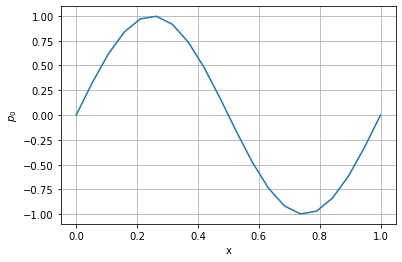

In [6]:
plt.plot(x, p0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('$p_0$')
plt.show()

In [7]:
from nangs import Dirichlet

initial_condition = Dirichlet({'x': x, 't': t[:1]}, {'p': p0}, name="initial")
pde.add_boco(initial_condition)

In [8]:
from nangs import Periodic

periodic = Periodic({'x': x[:1], 't': t}, {'x': x[-1:], 't': t})
pde.add_boco(periodic)

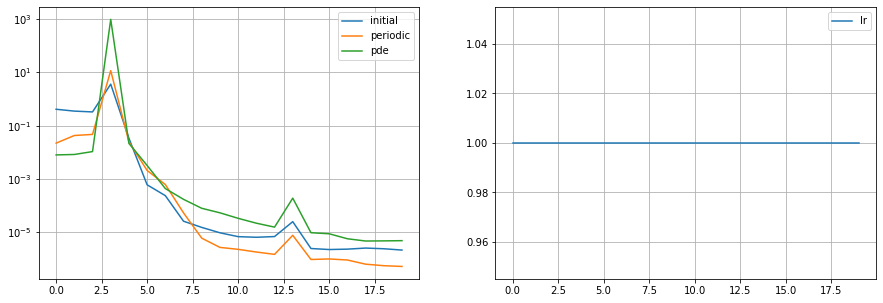

Wall time: 18.8 s


In [9]:
from nangs import MLP

LR = 1
EPOCHS = 20
NUM_LAYERS = 3
NUM_HIDDEN = 128
MAX_ITERS = 20

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN)
optimizer = torch.optim.LBFGS(mlp.parameters(), lr=LR, max_iter=MAX_ITERS)

pde.compile(mlp, optimizer)
%time hist = pde.solve(EPOCHS, use_closure=True)

In [10]:
from matplotlib import animation, rc
rc('animation', html='html5')

def update_plot(i, x, t, p):
    ax.clear()
    pe = np.sin(2.*np.pi*(x-U*t[i]))
    ax.plot(x, pe, label=f"exact (u = {U})")
    ax.plot(x, p[i], '.k', label="solution")
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("p", fontsize=14, rotation=np.pi/2)
    ax.legend(loc="upper right")
    ax.grid(True)
    ax.set_xlim([0, 1])
    ax.set_ylim([-1.2, 1.2])
    l2 = np.sqrt(np.sum((p[i]-pe)**2))
    ax.set_title(f"t = {t[i]:.3f} (L2 = {l2:.5f})")
    return ax

In [11]:
x = np.linspace(0,1,30)
t = np.linspace(0,1,20)

eval_mesh = Mesh({'x': x, 't': t})

p = pde.eval(eval_mesh)
p = p.cpu().numpy().reshape(len(t), -1)

fig = plt.figure()
ax = plt.subplot(111)
anim = animation.FuncAnimation(fig, update_plot, frames=len(t), fargs=(x, t, p), interval=300)
plt.close()

In [12]:
anim

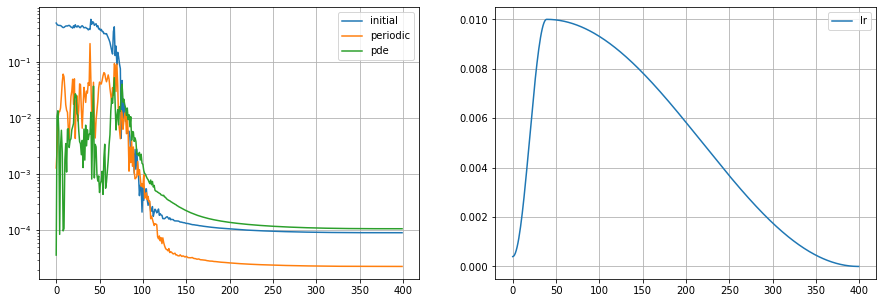

Wall time: 3min 14s


In [13]:
EPOCHS = 400
LR = 1e-2

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN)
optimizer = torch.optim.Adam(mlp.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, total_steps=EPOCHS)

pde.compile(mlp, optimizer, scheduler)
%time hist = pde.solve(EPOCHS)

In [14]:
x = np.linspace(0,1,30)
t = np.linspace(0,1,20)

eval_mesh = Mesh({'x': x, 't': t})

p = pde.eval(eval_mesh)
p = p.cpu().numpy().reshape(len(t), -1)

fig = plt.figure()
ax = plt.subplot(111)
anim = animation.FuncAnimation(fig, update_plot, frames=len(t), fargs=(x, t, p), interval=300)
plt.close()

In [15]:
anim